In [1]:
from dotenv import load_dotenv

_ = load_dotenv("../.env")

In [2]:
import geopandas as gpd
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode


In [3]:
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

In [4]:
loc_df = gpd.read_file("../data/gadm_410_small.gpkg")

In [5]:
query = "koraput"
match_df = gpd.read_file(
    "../data/gadm_410_small.gpkg",
    where=f"name like '%{query}%'")

In [6]:
match_df

GID_0     GID_1        GID_2          GID_3 GID_4 GID_5  \
0   IND  IND.26_1  IND.26.20_1  IND.26.20.1_1               
1   IND  IND.26_1  IND.26.20_1  IND.26.20.2_1               

                          name         gadmid  \
0  Jaypur Koraput Odisha India  IND.26.20.1_1   
1         Koraput Odisha India  IND.26.20.2_1   

                                            geometry  
0  MULTIPOLYGON (((82.0849 18.73269, 82.08675 18....  
1  MULTIPOLYGON (((83.06583 18.39316, 83.06583 18...

In [36]:
@tool
def location(query: str):
    "Returns location of a place"
    match_df = gpd.read_file(
        "../data/gadm_410_small.gpkg",
        where=f"name like '%{query}%'")
    return match_df.to_json()

@tool
def weather(query: str):
    "Retuns weather of a place"
    return f"The weather of {query} is hot & humid."

In [37]:
tools = [location, weather]
llm = llm.bind_tools(tools)

In [38]:
def should_continue(state):
    last_msg = state["messages"][-1]
    if not last_msg.tool_calls:
        return "end"
    else:
        return "continue"

def call_model(state):
    msgs = state["messages"]
    r = llm.invoke(msgs)
    return {"messages": [r]}

tool_node = ToolNode(tools)

In [51]:
wf = StateGraph(MessagesState)

wf.add_node("agent", call_model)
wf.add_node("action", tool_node)

wf.add_edge(START, "agent")
wf.add_conditional_edges("agent", should_continue,
                         {"end": END,
                          "continue": "action"
                         })
wf.add_edge("action", "agent")

memory = MemorySaver()
graph = wf.compile(checkpointer=memory, interrupt_after=["action"])

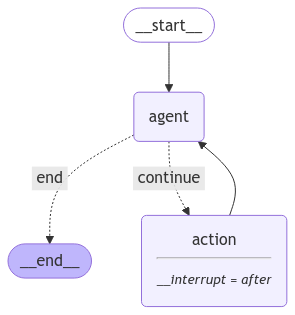

In [52]:
# display(Image(graph.get_graph().draw_mermaid_png()))

In [89]:
thread = {"configurable": {"thread_id": "4"}}
inputs = [HumanMessage(content="find location of koraput")]

for event in graph.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# thread = {"configurable": {"thread_id": "5"}}
# inputs = [HumanMessage(content="find weather of koraput")]

# for event in graph.stream({"messages": inputs}, thread, stream_mode="values"):
#     event["messages"][-1].pretty_print()

================================ Human Message =================================

find location of koraput
================================== Ai Message ==================================

[{'text': "I apologize for the confusion. It seems I've already provided you with the location of Koraput in my previous response. However, to ensure we have the most accurate and up-to-date information, I'll use the location tool again to find the location of Koraput.", 'type': 'text'}, {'id': 'toolu_011T9sS3tt33cm4HsbYAKV4j', 'input': {'query': 'Koraput'}, 'name': 'location', 'type': 'tool_use'}]
Tool Calls:
  location (toolu_011T9sS3tt33cm4HsbYAKV4j)
 Call ID: toolu_011T9sS3tt33cm4HsbYAKV4j
  Args:
    query: Koraput
================================= Tool Message =================================
Name: location

{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"GID_0": "IND", "GID_1": "IND.26_1", "GID_2": "IND.26.20_1", "GID_3": "IND.26.20.1_1", "GID_4": "",

In [90]:
cur_state = graph.get_state(thread)
tool_message = cur_state.values["messages"][-1]
tool_type = tool_message.name

In [91]:
if tool_type == "location":
    options = gpd.read_file(tool_message.content, driver="GeoJSON")
    for idx,row in options.iterrows():
        print(f"{idx}: {row['name']}")
    selected_idx = int(input("Please enter the number of the option you choose: "))
    selected_row = options.iloc[selected_idx]
    print("User Selected: ", selected_row["name"])

    # update content of tool_message
    tool_message.content = f"{selected_row['name']} is located in south east india, in Odisha."
    graph.update_state(thread, {"messages": tool_message})
elif tool_type == "weather":
    pass
else:
    print(f"Wrong tool type: {tool_type}")

/Users/srm/workdir/projects/wri/project-zeno/.venv/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


0: Jaypur Koraput Odisha India
1: Koraput Odisha India


Please enter the number of the option you choose:  1


User Selected:  Koraput Odisha India


In [92]:
# Continue graph
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: location

Koraput Odisha India is located in south east india, in Odisha.
================================== Ai Message ==================================

The location tool confirms the information I provided earlier. To summarize:

1. Koraput is located in Odisha, India.
2. It is situated in southeastern India.
3. Odisha is a state in the eastern part of India.

Koraput is a city and district in the state of Odisha. It's known for its hilly terrain, tribal culture, and agricultural products. The region is part of the Eastern Ghats mountain range, which contributes to its distinct geography and climate.

Is there any specific aspect of Koraput's location you'd like more information about, such as its coordinates, nearby cities, or geographical features?


In [93]:
for msg in graph.get_state(thread).values["messages"]:
    msg.pretty_print()

================================ Human Message =================================

find location of koraput
================================== Ai Message ==================================

[{'text': 'Certainly! I can help you find the location of Koraput using the location tool. Let me use that for you.', 'type': 'text'}, {'id': 'toolu_013cbJuW5aJEma1yUbuYhpeU', 'input': {'query': 'Koraput'}, 'name': 'location', 'type': 'tool_use'}]
Tool Calls:
  location (toolu_013cbJuW5aJEma1yUbuYhpeU)
 Call ID: toolu_013cbJuW5aJEma1yUbuYhpeU
  Args:
    query: Koraput
================================= Tool Message =================================
Name: location

Koraput Odisha India is located in south east india, in Odisha.
================================== Ai Message ==================================

Based on the information provided by the location tool, Koraput is located in Odisha, India. More specifically:

1. Koraput is a city in the state of Odisha (formerly known as Orissa).
2. It is si